In [2]:
import pandas as pd
import numpy as np
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Models
def linear(x, a, b): return a * x + b
def quadratic(x, a, b, c): return a * x**2 + b * x + c
def power_law(x, k, p): return k * x**p

# Slippage simulator (for BUY orders)
def calculate_slippage(order_sizes, row, side='buy'):
    levels = 10
    prices = []
    sizes = []
    if side == 'buy':
        for i in range(levels):
            price = row[f'ask_px_0{i}']
            size = row[f'ask_sz_0{i}']
            prices.append(price)
            sizes.append(size)
    else:
        for i in range(levels):
            price = row[f'bid_px_0{i}']
            size = row[f'bid_sz_0{i}']
            prices.append(price)
            sizes.append(size)

    gxs = []
    p0 = prices[0]  # best price
    for x in order_sizes:
        remaining = x
        cost = 0
        for price, size in zip(prices, sizes):
            if remaining <= size:
                cost += remaining * price
                remaining = 0
                break
            else:
                cost += size * price
                remaining -= size
        if remaining > 0:
            gxs.append(np.nan)  # not enough liquidity
        else:
            avg_price = cost / x
            gxs.append(avg_price - p0)
    return gxs


In [3]:
def process_ticker(ticker_path, order_sizes, sample_every_n=500):
    x_vals = []
    g_vals = []

    files = [f for f in os.listdir(ticker_path) if f.endswith('.csv')]
    for fname in files:
        df = pd.read_csv(os.path.join(ticker_path, fname))
        df = df.iloc[::sample_every_n]  # sample every Nth row to reduce load

        for _, row in df.iterrows():
            slippages = calculate_slippage(order_sizes, row)
            for x, gx in zip(order_sizes, slippages):
                if not np.isnan(gx):
                    x_vals.append(x)
                    g_vals.append(gx)
    return np.array(x_vals), np.array(g_vals)


In [4]:
def fit_and_plot(x_vals, g_vals, ticker_name):
    models = {
        "Linear": (linear, 2),
        "Quadratic": (quadratic, 3),
        "Power Law": (power_law, 2)
    }

    plt.figure(figsize=(8,6))
    plt.scatter(x_vals, g_vals, alpha=0.4, label="Data")

    x_line = np.linspace(min(x_vals), max(x_vals), 200)

    for name, (model, _) in models.items():
        try:
            popt, _ = curve_fit(model, x_vals, g_vals, maxfev=10000)
            y_line = model(x_line, *popt)
            r2 = 1 - np.sum((g_vals - model(x_vals, *popt))**2) / np.sum((g_vals - np.mean(g_vals))**2)
            plt.plot(x_line, y_line, label=f"{name} (R²={r2:.3f})")
            print(f"{ticker_name} | {name} model params: {popt}, R² = {r2:.3f}")
        except Exception as e:
            print(f"{ticker_name} | {name} fit failed: {e}")

    plt.title(f"Slippage Model Fit for {ticker_name}")
    plt.xlabel("Order Size x")
    plt.ylabel("Slippage g_t(x)")
    plt.legend()
    plt.grid(True)
    plt.show()


CRWV | Linear model params: [3.01332466e-05 5.87201008e-02], R² = 0.097
CRWV | Quadratic model params: [-1.45200463e-08  9.35798281e-05  1.73184602e-02], R² = 0.135
CRWV | Power Law model params: [0.00532071 0.41968738], R² = 0.122


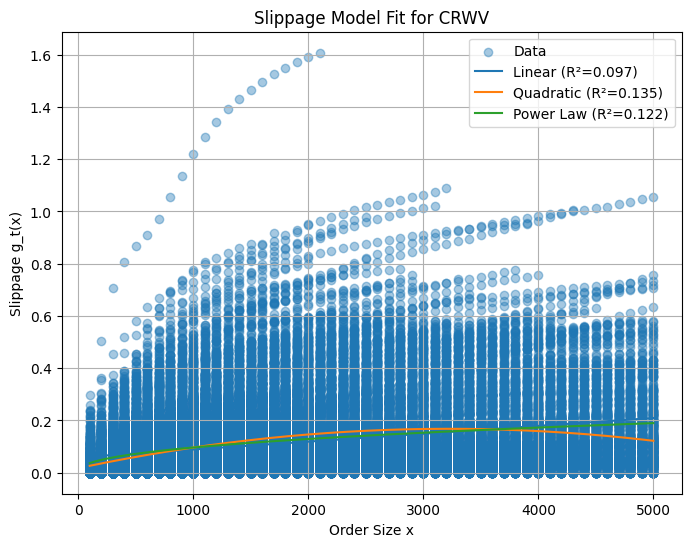

FROG | Linear model params: [4.85696681e-05 4.14782459e-02], R² = 0.082
FROG | Quadratic model params: [-2.98564850e-08  1.55334724e-04 -1.76693145e-02], R² = 0.144
FROG | Power Law model params: [0.00225736 0.54767604], R² = 0.103


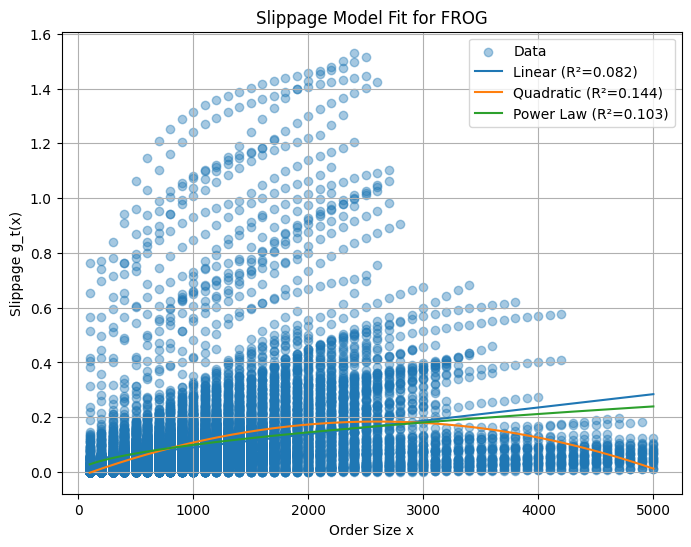

SOUN | Linear model params: [1.65203521e-06 6.72916640e-04], R² = 0.154
SOUN | Quadratic model params: [-1.59193961e-10  2.46377810e-06 -3.03904821e-05], R² = 0.156
SOUN | Power Law model params: [1.04587292e-05 7.88412349e-01], R² = 0.155


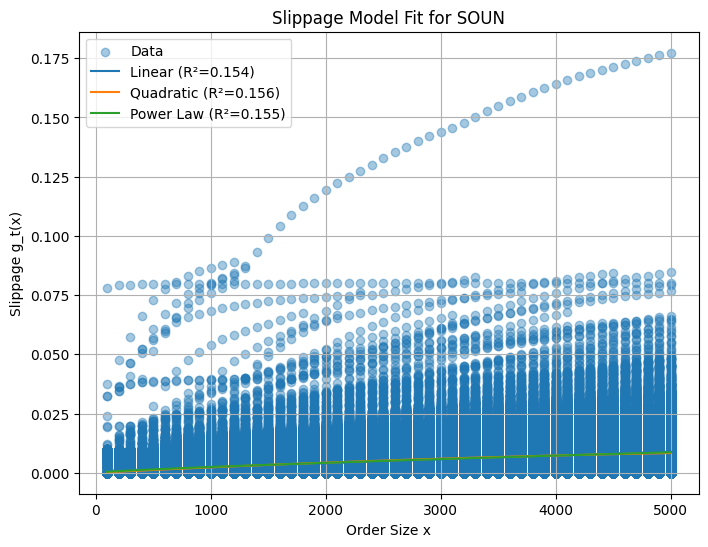

In [6]:
ticker_dirs = {
    "CRWV": "/Users/rkoushik6/Desktop/blockchain/CRWV",
    "FROG": "/Users/rkoushik6/Desktop/blockchain/FROG",
    "SOUN": "/Users/rkoushik6/Desktop/blockchain/SOUN"
}

order_sizes = np.arange(100, 5100, 100)

for ticker, path in ticker_dirs.items():
    x_vals, g_vals = process_ticker(path, order_sizes)
    fit_and_plot(x_vals, g_vals, ticker)
